In [1]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation, NumpyToTorch

from agent import DQNAgent, DDPGAgent
from utils import preprocess_state, show_epsilon_decay, show_frame, PlotResults

# Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Q-Network

### Test on CartPole env

In [3]:
env = gym.make('CartPole-v1')
env = NumpyToTorch(env, device)
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model_type='DQN',
    name='CartPole',
    device=device,
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=1e-3,
    tau=0.005,
    lr=1e-3,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = PlotResults()
n_episodes = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: 30.00, Epsilon: 0.95
Episode 10, Average Reward: 17.00, Epsilon: 0.83
Episode 20, Average Reward: 20.80, Epsilon: 0.67
Episode 30, Average Reward: 22.60, Epsilon: 0.54
Episode 40, Average Reward: 28.10, Epsilon: 0.41
Episode 50, Average Reward: 154.30, Epsilon: 0.09
Episode 60, Average Reward: 272.50, Epsilon: 0.01
Episode 70, Average Reward: 214.80, Epsilon: 0.01
Episode 80, Average Reward: 189.00, Epsilon: 0.01
Episode 90, Average Reward: 165.80, Epsilon: 0.01


In [4]:
# save the model
dqn_agent.save_models()

In [ ]:
env = gym.make('CartPole-v1', render_mode='human')
env = NumpyToTorch(env, device)

# Load the agent with just name and device
agent = DQNAgent.load_agent('CartPole', device)

state, _ = env.reset()
done = False
total_reward = 0
while not done:
    action = agent.select_action(state, eval_mode=True)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward

print(f"Total Reward: {total_reward}")

Total Reward: 149.0


: 

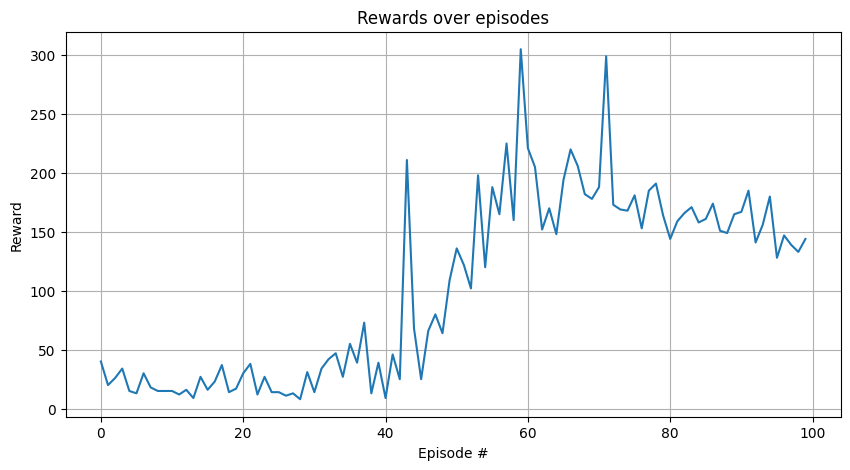

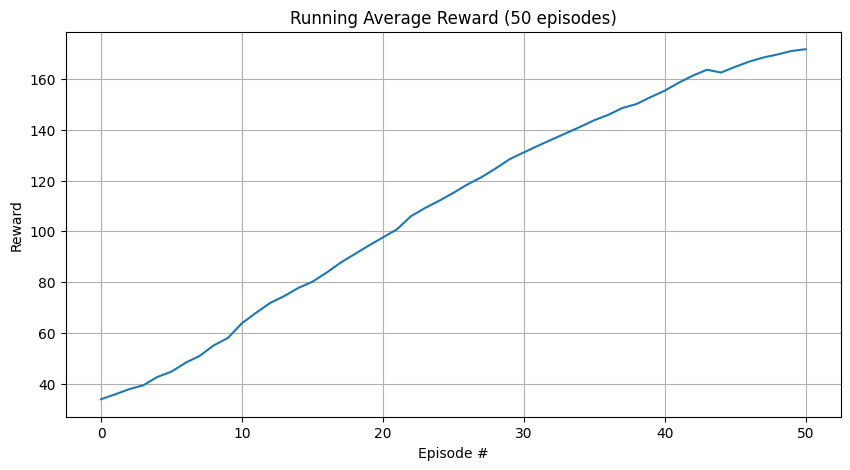

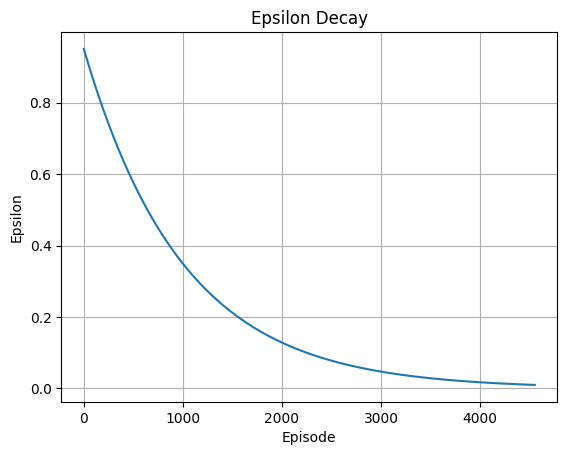

In [5]:
# Plot the rewards
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=50)
show_epsilon_decay(dqn_agent.epsilon_start, dqn_agent.epsilon_min, dqn_agent.epsilon_decay)

### Test on LunarLander env

In [ ]:
env = gym.make('LunarLander-v3')
env = NumpyToTorch(env, device)
# print(env.action_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape[0]
n_observations = (n_observations, )

dqn_agent = DQNAgent(
    model_type='DQN',
    name='LunarLander',
    device=device,
    batch_size=64,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.01,
    epsilon_decay=1e-4,
    tau=0.005,
    lr=1e-3,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = PlotResults()
n_episodes = 100

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dqn_agent.store_transition(state, action, next_state, reward, done)
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")

Episode 0, Average Reward: -104.24, Epsilon: 0.95
Episode 10, Average Reward: -184.62, Epsilon: 0.86
Episode 20, Average Reward: -202.91, Epsilon: 0.77
Episode 30, Average Reward: -149.61, Epsilon: 0.69
Episode 40, Average Reward: -77.81, Epsilon: 0.61
Episode 50, Average Reward: -86.22, Epsilon: 0.53
Episode 60, Average Reward: -53.21, Epsilon: 0.46
Episode 70, Average Reward: -19.99, Epsilon: 0.32
Episode 80, Average Reward: -101.05, Epsilon: 0.25
Episode 90, Average Reward: -125.85, Epsilon: 0.14


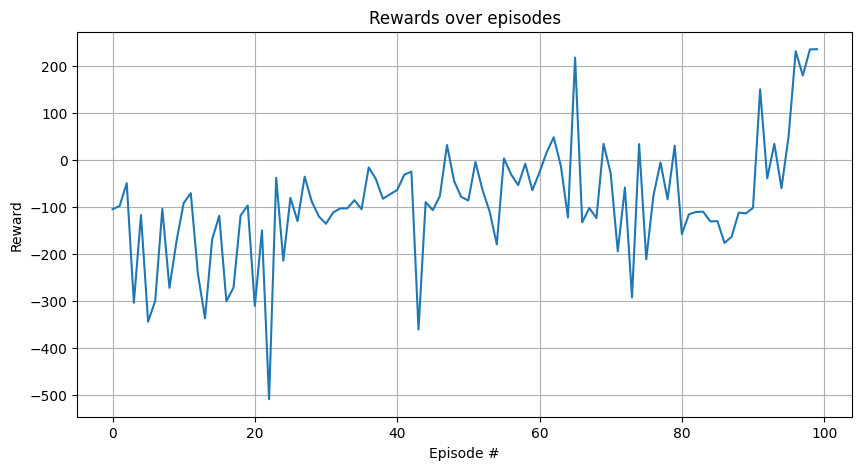

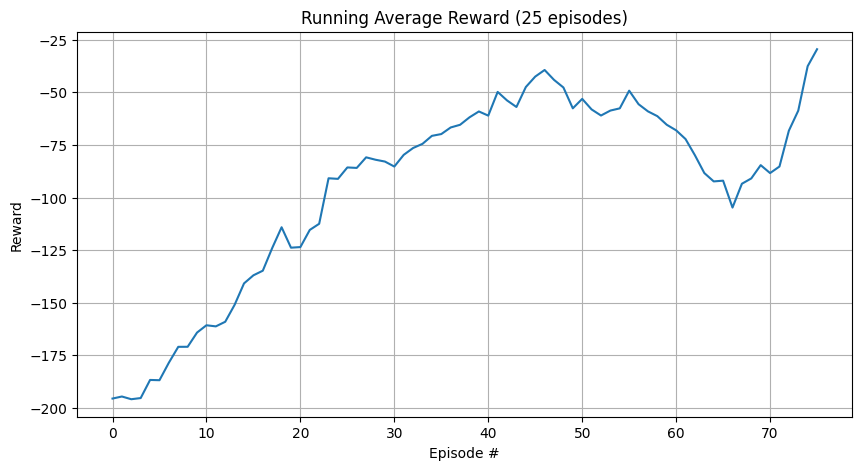

In [8]:
rewards_storer.plot_rewards()
rewards_storer.plot_rewards_smooth(window_length=25)

### Deep Q-Netowrk with CNN architecture

In [ ]:
env = gym.make('CarRacing-v3', continuous=False)
env = FrameStackObservation(env, 4)
env = NumpyToTorch(env, device)
# print(env.observation_space)
n_actions, n_observations = env.action_space.n, env.observation_space.shape
n_observations = (n_observations[1], n_observations[2], n_observations[0])  # (height, width, frames)

# print(n_actions, n_observations)
START_SKIP = 15 # to skip the nth frames at the beginning of the episode
dqn_agent = DQNAgent(
    model_type='DQN_CNN',
    name='CarRacing',
    device=device,
    batch_size=128,
    gamma=0.99,
    epsilon_start=0.95,
    epsilon_min=0.02,
    epsilon_decay=1e-5,
    tau=0.005,
    lr=1e-4,
    memory_capacity=10000,
    action_space=n_actions,
    observation_space=n_observations
)

rewards_storer = PlotResults()
n_episodes = 10

for episode in range(n_episodes):
    state, _ = env.reset()
    for _ in range(START_SKIP):
        # Take random actions during the skip phase
        random_action = np.random.randint(n_actions)
        state, _, _, _, _ = env.step(random_action)
    
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Preprocess the next state
        next_state = preprocess_state(next_state)

        # Store the transition in the replay buffer
        dqn_agent.store_transition(state, action, next_state, reward, done)

        # Train the agent
        dqn_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 1 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-10:]):.2f}, Epsilon: {dqn_agent.epsilon:.2f}")



KeyboardInterrupt: 

401


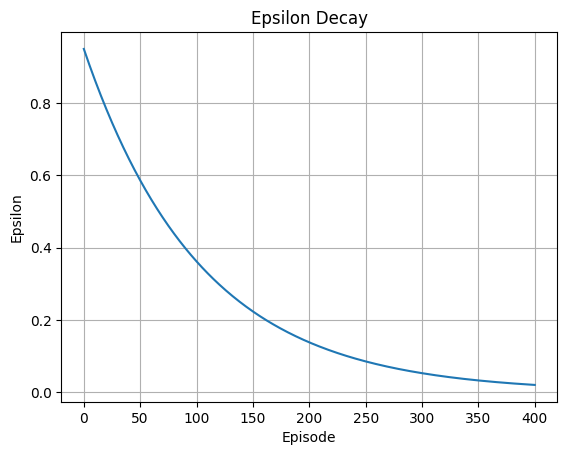

In [13]:
show_epsilon_decay(0.95, 0.02, 400)

In [74]:
tmp_env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=False)
tmp_env = FrameStackObservation(tmp_env, 4)
# wrap the env in the record video
env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="video", episode_trigger=lambda x: True)

state, _ = env.reset()
# Start the recorder
env.start_recording('test')

test_episodes = 5
# AI logic
for episode in range(test_episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        # Reduce state and next_state to greyscale
        next_state = preprocess_state(next_state)

        state = next_state
        total_reward += reward


env.stop_recording()

# Close the environment
env.close()

c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\tfore\Desktop\INF8225_Project\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\tfore\anaconda3\envs\DeepRL\lib\site-packages\gymnasium\wrappers\rendering.py:395: UserWarning: WARN: Ignored saving a video as there were zero frames to save.
  logger.warn("Ignored saving a video as there were zero frames to save.")


# Deep Deterministic Policy Gradient (DDPG)

### Test on continous mountain car env

In [7]:
env = gym.make('MountainCarContinuous-v0')
env = NumpyToTorch(env, device)
n_actions, n_observations = env.action_space.shape, env.observation_space.shape[0]
n_observations = (n_observations, )
# print(n_actions, n_observations)


ddpg_agent = DDPGAgent(
    model='DDPG',
    device=device,
    batch_size=64,
    gamma=0.99,
    tau=0.005,
    lr_actor=2.5e-3,
    lr_critic=1e-4,
    memory_capacity=100000,
    action_space=n_actions,
    observation_space=n_observations
)
rewards_storer = PlotResults()
n_episodes = 200

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    # print(state)
    while not done:
        action = ddpg_agent.select_action(state)
        action = action[0].detach()
        next_state, reward, terminated, truncated, _ = env.step(action) # TODO: check if action[0] is correct for all env
        done = terminated or truncated
        if terminated:
            print("GOAL REACHED at episode", episode)
        # print(next_state, action, reward)
        
        ddpg_agent.store_transition(state, action, next_state, reward, done)
        ddpg_agent.train()
        state = next_state
        total_reward += reward
    rewards_storer.add(total_reward)
    if episode % 5 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(rewards_storer.get_rewards()[-5:]):.2f}")

Episode 0, Average Reward: -7.37
Episode 5, Average Reward: -9.86
Episode 10, Average Reward: -12.65
Episode 15, Average Reward: -14.67
Episode 20, Average Reward: -21.46
Episode 25, Average Reward: -7.84
Episode 30, Average Reward: -7.95
Episode 35, Average Reward: -20.11
Episode 40, Average Reward: -13.45
Episode 45, Average Reward: -4.75
Episode 50, Average Reward: -22.42
Episode 55, Average Reward: -12.71
Episode 60, Average Reward: -6.48
Episode 65, Average Reward: -17.88
Episode 70, Average Reward: -9.13
Episode 75, Average Reward: -26.05
Episode 80, Average Reward: -10.77
Episode 85, Average Reward: -11.42
Episode 90, Average Reward: -25.07
Episode 95, Average Reward: -8.93
Episode 100, Average Reward: -19.45
Episode 105, Average Reward: -31.34
Episode 110, Average Reward: -15.38
Episode 115, Average Reward: -26.07
Episode 120, Average Reward: -9.49
Episode 125, Average Reward: -10.29
Episode 130, Average Reward: -7.60
Episode 135, Average Reward: -6.46
Episode 140, Average Rewa

KeyboardInterrupt: 